<a href="https://colab.research.google.com/github/zzangdol1029/RADAR/blob/main/notebook/log_anomaly_DAGMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DAGMM

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import os
import zipfile
import glob
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}\n")

class DAGMM_Embedding(nn.Module):
    """Embedding을 사용한 DAGMM"""

    def __init__(self, num_classes, window_size=10, embedding_dim=32,
                 hidden_dims=[64, 32], latent_dim=2, n_gmm=4, dropout=0.3):
        super(DAGMM_Embedding, self).__init__()

        self.num_classes = num_classes
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.n_gmm = n_gmm

        # Embedding Layer
        self.embedding = nn.Embedding(num_classes, embedding_dim, padding_idx=0)

        input_dim = window_size * embedding_dim  # 10 * 32 = 320 (기존 1330에서 대폭 감소!)

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, h),
                nn.ReLU(),  # Tanh 대신 ReLU (더 안정적)
                nn.BatchNorm1d(h),  # Batch Normalization 추가
                nn.Dropout(dropout)
            ])
            prev_dim = h
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        prev_dim = latent_dim
        for h in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, h),
                nn.ReLU(),
                nn.BatchNorm1d(h),
                nn.Dropout(dropout)
            ])
            prev_dim = h
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

        # Estimation Network
        self.estimation_dim = latent_dim + 2
        self.estimation = nn.Sequential(
            nn.Linear(self.estimation_dim, 10),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(10, n_gmm),
            nn.Softmax(dim=1)
        )

        # GMM 파라미터
        self.register_buffer('phi', torch.ones(n_gmm) / n_gmm)  # 균등 초기화
        self.register_buffer('mu', torch.zeros(n_gmm, self.estimation_dim))
        self.register_buffer('sigma', torch.eye(self.estimation_dim).unsqueeze(0).repeat(n_gmm, 1, 1))

    def forward(self, x):
        """
        Args:
            x: (batch, window_size) - 정수 인덱스
        """
        # Embedding
        embedded = self.embedding(x)  # (batch, window_size, embedding_dim)
        x_flat = embedded.view(x.size(0), -1)  # (batch, window_size * embedding_dim)

        # Autoencoder
        z = self.encoder(x_flat)
        x_hat = self.decoder(z)

        # 재구성 오차
        rec_euc = torch.norm(x_flat - x_hat, p=2, dim=1, keepdim=True) / (torch.norm(x_flat, p=2, dim=1, keepdim=True) + 1e-6)
        rec_cos = (1 - F.cosine_similarity(x_flat, x_hat, dim=1, eps=1e-6)).unsqueeze(1)

        # 클리핑 (수치 안정성)
        rec_euc = torch.clamp(rec_euc, 0, 10)
        rec_cos = torch.clamp(rec_cos, 0, 2)

        z_c = torch.cat([z, rec_euc, rec_cos], dim=1)
        gamma = self.estimation(z_c)

        return z, x_hat, z_c, gamma, x_flat

    def compute_gmm_params(self, z_c, gamma):
        N = z_c.shape[0]
        sum_gamma = torch.sum(gamma, dim=0) + 1e-6  # 0 방지

        phi = sum_gamma / N
        mu = torch.sum(gamma.unsqueeze(-1) * z_c.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)

        z_centered = z_c.unsqueeze(1) - mu.unsqueeze(0)
        z_exp = z_centered.unsqueeze(-1)
        z_exp_T = z_centered.unsqueeze(-2)

        sigma = torch.sum(
            gamma.unsqueeze(-1).unsqueeze(-1) * (z_exp @ z_exp_T), dim=0
        ) / sum_gamma.unsqueeze(-1).unsqueeze(-1)

        return phi, mu, sigma

    def compute_energy(self, z_c, phi=None, mu=None, sigma=None):
        if phi is None: phi = self.phi
        if mu is None: mu = self.mu
        if sigma is None: sigma = self.sigma

        N = z_c.shape[0]
        eps = 1e-6

        z_centered = z_c.unsqueeze(1) - mu.unsqueeze(0)

        # 더 강한 정규화
        sigma_reg = sigma + eps * torch.eye(self.estimation_dim, device=sigma.device).unsqueeze(0)

        # 역행렬 직접 계산 (Cholesky 대신 - 더 안정적)
        try:
            sigma_inv = torch.linalg.inv(sigma_reg)
            log_det = torch.logdet(sigma_reg)
        except:
            # 실패 시 대각 근사
            sigma_diag = torch.diagonal(sigma_reg, dim1=-2, dim2=-1)
            sigma_inv = torch.diag_embed(1.0 / (sigma_diag + eps))
            log_det = torch.sum(torch.log(sigma_diag + eps), dim=-1)

        # Mahalanobis distance
        mahal = torch.zeros(N, self.n_gmm, device=z_c.device)
        for k in range(self.n_gmm):
            diff = z_centered[:, k, :]  # (N, estimation_dim)
            mahal[:, k] = torch.sum(diff @ sigma_inv[k] * diff, dim=1)

        # 클리핑 (폭발 방지)
        mahal = torch.clamp(mahal, 0, 1000)

        d = self.estimation_dim
        log_probs = -0.5 * (d * np.log(2 * np.pi) + log_det.unsqueeze(0) + mahal)

        log_phi = torch.log(phi.unsqueeze(0) + eps)
        log_weighted = log_phi + log_probs

        # Clipping before exp
        log_weighted = torch.clamp(log_weighted, -50, 50)

        max_log = torch.max(log_weighted, dim=1, keepdim=True)[0]
        log_sum_exp = max_log + torch.log(torch.sum(torch.exp(log_weighted - max_log), dim=1, keepdim=True) + eps)

        energy = -log_sum_exp.squeeze(1)

        # 최종 클리핑
        energy = torch.clamp(energy, -10, 100)

        return energy

# ==================== 데이터셋 (정수 인덱스 반환) ====================
class LogDataset(Dataset):
    def __init__(self, sequences, window_size=10):
        self.window_size = window_size
        self.samples = []

        for seq in sequences:
            if len(seq) < window_size:
                self.samples.append(seq + [0] * (window_size - len(seq)))
            else:
                for i in range(len(seq) - window_size + 1):
                    self.samples.append(seq[i:i+window_size])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.LongTensor(self.samples[idx])  # 정수 인덱스 반환

# ==================== 손실 함수 (개선) ====================
class DAGMMLoss(nn.Module):
    def __init__(self, lambda_energy=0.1, lambda_diag=0.005):
        super().__init__()
        self.le = lambda_energy
        self.ld = lambda_diag

    def forward(self, x, x_hat, energy, sigma):
        rec = F.mse_loss(x_hat, x)
        eng = torch.mean(energy)

        # Diagonal penalty
        diag = torch.sum(sigma ** 2) - torch.sum(torch.diagonal(sigma, dim1=-2, dim2=-1) ** 2)

        total = rec + self.le * eng + self.ld * diag
        return total, rec, eng, diag

# ==================== 학습/평가 ====================
def train(model, loader, opt, crit, dev, epoch):
    model.train()
    tl = tr = te = td = 0

    for batch_idx, data in enumerate(loader):
        data = data.to(dev)
        z, x_hat, z_c, gamma, x_flat = model(data)

        phi, mu, sigma = model.compute_gmm_params(z_c, gamma)

        with torch.no_grad():
            if epoch == 0 and batch_idx == 0:
                model.phi = phi
                model.mu = mu
                model.sigma = sigma
            else:
                m = 0.9
                model.phi = m * model.phi + (1-m) * phi
                model.mu = m * model.mu + (1-m) * mu
                model.sigma = m * model.sigma + (1-m) * sigma

        energy = model.compute_energy(z_c, phi, mu, sigma)
        loss, rec, eng, diag = crit(x_flat, x_hat, energy, sigma)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        tl += loss.item()
        tr += rec.item()
        te += eng.item()
        td += diag.item()

    n = len(loader)
    return tl/n, tr/n, te/n, td/n

def evaluate(model, loader, crit, dev):
    model.eval()
    tl = tr = 0
    energies = []

    with torch.no_grad():
        for data in loader:
            data = data.to(dev)
            z, x_hat, z_c, gamma, x_flat = model(data)
            energy = model.compute_energy(z_c)
            loss, rec, _, _ = crit(x_flat, x_hat, energy, model.sigma)

            tl += loss.item()
            tr += rec.item()
            energies.extend(energy.cpu().numpy())

    n = len(loader)
    return tl/n, tr/n, np.array(energies)

# ==================== 데이터 로드 ====================
def load_data(path):
    zip_path = os.path.join(path, 'logFile.zip')
    extract_path = './logs'
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)

    sessions = []
    for f in glob.glob(os.path.join(extract_path, '**/*.json'), recursive=True):
        with open(f, 'r') as fp:
            data = json.load(fp)
            sessions.extend(data) if isinstance(data, list) else sessions.append(data)

    print(f"총 세션: {len(sessions):,}\n")
    return sessions

def prepare(sessions):
    seqs = []
    ids = set()

    for s in sessions:
        seq = s.get('event_sequence', [])
        if seq:
            seqs.append(seq)
            ids.update(seq)

    id_map = {e: i+1 for i, e in enumerate(sorted(ids))}
    id_map[0] = 0
    seqs_remap = [[id_map.get(e, 0) for e in s] for s in seqs]

    print(f"시퀀스: {len(seqs):,}, 클래스: {len(id_map)}\n")
    return seqs_remap, len(id_map)

# ==================== 메인 ====================
print("=" * 50)
print("개선된 DAGMM (Embedding)")
print("=" * 50)

sessions = load_data('/content/drive/MyDrive/로그이상탐지/dataset/')
seqs, n_cls = prepare(sessions)

# Train/Test 분할
n = len(seqs)
idx = np.random.permutation(n)
split = int(n * 0.2)
train_s = [seqs[i] for i in idx[split:]]
test_s = [seqs[i] for i in idx[:split]]

window_size = 10
train_ds = LogDataset(train_s, window_size)
test_ds = LogDataset(test_s, window_size)

# 배치 크기 증가 (속도 향상)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print(f"학습: {len(train_ds):,}, 테스트: {len(test_ds):,}\n")

# 모델 초기화
model = DAGMM_Embedding(
    num_classes=n_cls,
    window_size=window_size,
    embedding_dim=32,
    hidden_dims=[64, 32],
    latent_dim=2,
    n_gmm=4,
    dropout=0.3
).to(device)

print(f"입력: {window_size}*{32}={window_size*32}, 파라미터: {sum(p.numel() for p in model.parameters()):,}\n")

criterion = DAGMMLoss(0.1, 0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 학습률 증가

print("=" * 50)
print("학습 시작")
print("=" * 50)

best = float('inf')
for epoch in range(50):  # 50 epoch로 감소
    tl, tr, te, td = train(model, train_ld, optimizer, criterion, device, epoch)
    vl, vr, ve = evaluate(model, test_ld, criterion, device)

    if vl < best:
        best = vl
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'n_cls': n_cls,
            'window': window_size
        }, 'dagmm_embed.pth')

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:3d} | Train: {tl:.4f} (R:{tr:.4f} E:{te:.2f}) | Test: {vl:.4f} (R:{vr:.4f}) | Energy: {ve.mean():.2f}±{ve.std():.2f}")

print(f"\n✅ 완료! 최저: {best:.4f}")

Mounted at /content/drive
사용 디바이스: cuda

개선된 DAGMM (Embedding)
총 세션: 462,328

시퀀스: 462,328, 클래스: 133

학습: 370,445, 테스트: 92,607

입력: 10*32=320, 파라미터: 50,432

학습 시작
Epoch   5 | Train: -0.9947 (R:0.0043 E:-9.99) | Test: -0.9943 (R:0.0032) | Energy: -9.98±0.21
Epoch  10 | Train: -0.9990 (R:0.0007 E:-10.00) | Test: -0.9993 (R:0.0006) | Energy: -10.00±0.03
Epoch  15 | Train: -0.9995 (R:0.0004 E:-10.00) | Test: -0.9994 (R:0.0003) | Energy: -10.00±0.06
Epoch  20 | Train: -0.9996 (R:0.0003 E:-10.00) | Test: -0.9997 (R:0.0003) | Energy: -10.00±0.00
Epoch  25 | Train: -0.9993 (R:0.0003 E:-10.00) | Test: -0.9984 (R:0.0003) | Energy: -9.99±0.14
Epoch  30 | Train: -0.9998 (R:0.0001 E:-10.00) | Test: -0.9999 (R:0.0001) | Energy: -10.00±0.01
Epoch  35 | Train: -0.9998 (R:0.0001 E:-10.00) | Test: -0.9999 (R:0.0001) | Energy: -10.00±0.10
Epoch  40 | Train: -0.9999 (R:0.0001 E:-10.00) | Test: -0.9998 (R:0.0001) | Energy: -10.00±0.19
Epoch  45 | Train: -0.9999 (R:0.0001 E:-10.00) | Test: -0.9997 (R:0.0001

DAGMM 성능 평가
✅ 모델 로드 완료

1단계: 정상 데이터 Energy 분석
------------------------------------------------------------
정상 데이터 Energy 통계:
  평균: -9.8596
  표준편차: 1.2418
  최소: -10.0000
  최대: 2.9087
  중앙값: -10.0000
  50th percentile: -10.0000
  75th percentile: -10.0000
  90th percentile: -10.0000
  95th percentile: -10.0000
  99th percentile: 0.7815

2단계: 이상 탐지 성능 평가
------------------------------------------------------------
정상 샘플: 64,770개
이상 샘플: 27,758개

Energy 통계:
정상 데이터: -9.8557 ± 1.2595
이상 데이터: -7.7378 ± 3.3402

3단계: 최적 임계값 탐색
------------------------------------------------------------
최적 임계값: -10.0000
  Precision: 0.9484
  Recall:    0.5910
  F1-Score:  0.7282
  Accuracy:  0.8677
  TP=16406, FP=892, TN=63878, FN=11352

4단계: ROC 및 PR Curve 계산
------------------------------------------------------------
ROC AUC: 0.7854
PR AUC:  0.7732

5단계: 시각화 생성
------------------------------------------------------------
✅ 시각화 저장: dagmm_evaluation.png


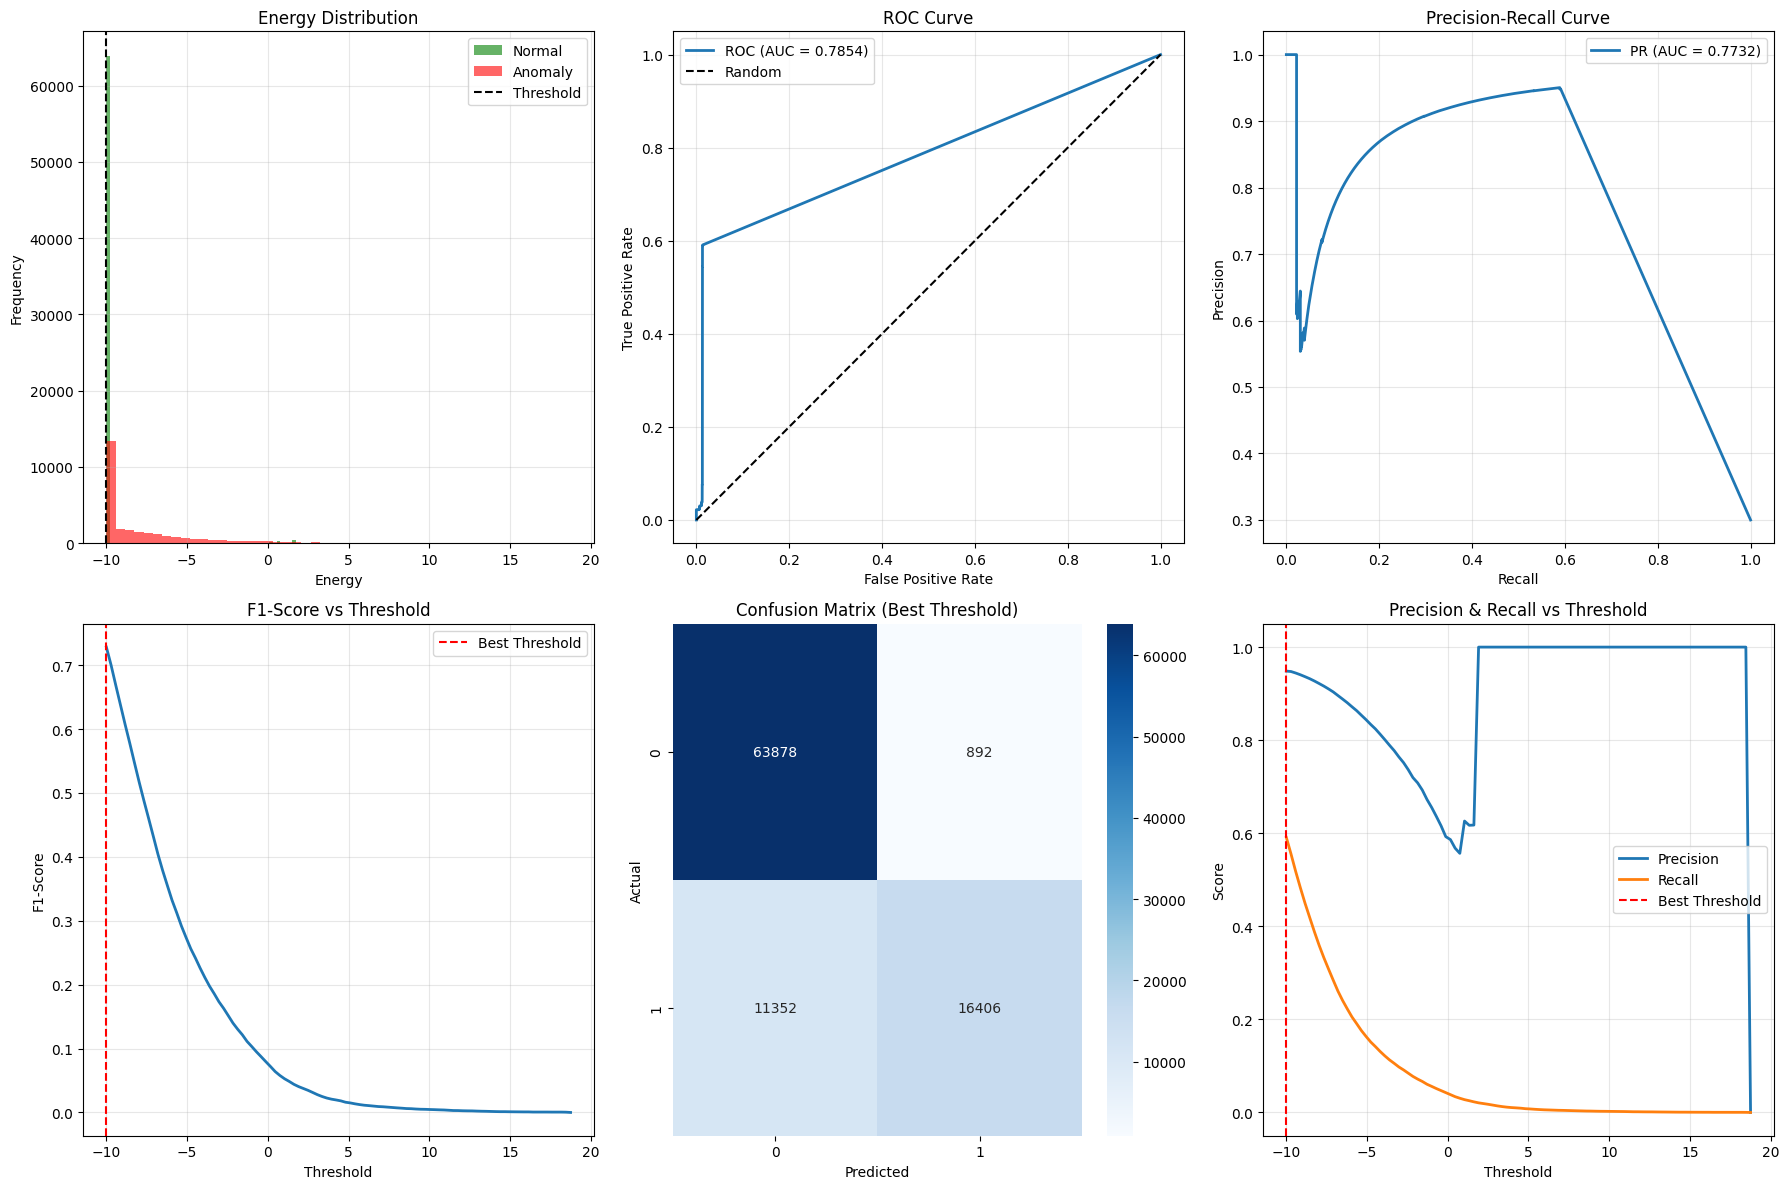


DAGMM 성능 평가 보고서

1. 데이터 정보
   - 전체 테스트 샘플: 92,528개
   - 정상 샘플: 64,770개 (70.0%)
   - 이상 샘플: 27,758개 (30.0%)

2. Energy 통계
   - 정상 데이터: -9.8557 ± 1.2595
   - 이상 데이터: -7.7378 ± 3.3402
   - 분리도 (차이): 2.1179

3. 최적 임계값: -10.0000
   - Precision: 0.9484 (94.84%)
   - Recall:    0.5910 (59.10%)
   - F1-Score:  0.7282 (72.82%)
   - Accuracy:  0.8677 (86.77%)

4. 혼동 행렬
   - True Positive (TP):  16,406개 (이상을 이상으로 정확히 탐지)
   - True Negative (TN):  63,878개 (정상을 정상으로 정확히 판단)
   - False Positive (FP): 892개 (정상을 이상으로 오탐)
   - False Negative (FN): 11,352개 (이상을 정상으로 놓침)

5. AUC 점수
   - ROC AUC: 0.7854
   - PR AUC:  0.7732

6. 해석
   - ROC AUC > 0.9: 우수
   - PR AUC > 0.8: 우수
   - F1-Score > 0.85: 우수

✅ 보고서 저장: dagmm_evaluation_report.txt


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns

# ==================== 1. 모델 로드 ====================
print("=" * 60)
print("DAGMM 성능 평가")
print("=" * 60)

# 저장된 모델 로드
checkpoint = torch.load('dagmm_fast.pth')
model.load_state_dict(checkpoint['model'])
model.eval()

print("✅ 모델 로드 완료\n")

# ==================== 2. 정상 데이터 Energy 분포 분석 ====================
print("1단계: 정상 데이터 Energy 분석")
print("-" * 60)

normal_energies = []

with torch.no_grad():
    for data in test_ld:
        data = data.to(device)
        z, x_hat, z_c, gamma, emb = model(data)
        energy = model.compute_energy(z_c)
        normal_energies.extend(energy.cpu().numpy())

normal_energies = np.array(normal_energies)

print(f"정상 데이터 Energy 통계:")
print(f"  평균: {normal_energies.mean():.4f}")
print(f"  표준편차: {normal_energies.std():.4f}")
print(f"  최소: {normal_energies.min():.4f}")
print(f"  최대: {normal_energies.max():.4f}")
print(f"  중앙값: {np.median(normal_energies):.4f}")

# 백분위수
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(normal_energies, p)
    print(f"  {p}th percentile: {val:.4f}")

print()

# ==================== 3. 이상 데이터 생성 및 평가 ====================
print("2단계: 이상 탐지 성능 평가")
print("-" * 60)

def inject_anomalies(dataset, anomaly_ratio=0.3):
    """정상 데이터에 이상 주입"""
    n_samples = len(dataset)
    n_anomalies = int(n_samples * anomaly_ratio)

    # 무작위로 이상 인덱스 선택
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)

    # 데이터 복사
    anomaly_dataset = []
    labels = []

    for idx in range(n_samples):
        sample = dataset.samples[idx].copy()

        if idx in anomaly_indices:
            # 이상 주입: 무작위 이벤트로 일부 교체
            n_replace = np.random.randint(1, len(sample) // 2 + 1)
            replace_positions = np.random.choice(len(sample), n_replace, replace=False)

            for pos in replace_positions:
                # 현재 값과 다른 무작위 값
                current_val = sample[pos]
                new_val = np.random.randint(1, len(id_map))
                while new_val == current_val:
                    new_val = np.random.randint(1, len(id_map))
                sample[pos] = new_val

            labels.append(1)  # 이상
        else:
            labels.append(0)  # 정상

        anomaly_dataset.append(sample)

    return anomaly_dataset, np.array(labels)

# 이상 데이터 생성
anomaly_samples, true_labels = inject_anomalies(test_ds, anomaly_ratio=0.3)

print(f"정상 샘플: {(true_labels == 0).sum():,}개")
print(f"이상 샘플: {(true_labels == 1).sum():,}개")
print()

# Energy 계산
all_energies = []

with torch.no_grad():
    for sample in anomaly_samples:
        data = torch.LongTensor([sample]).to(device)
        z, x_hat, z_c, gamma, emb = model(data)
        energy = model.compute_energy(z_c)
        all_energies.append(energy.item())

all_energies = np.array(all_energies)

# 정상/이상 Energy 분리
normal_test_energies = all_energies[true_labels == 0]
anomaly_energies = all_energies[true_labels == 1]

print("Energy 통계:")
print(f"정상 데이터: {normal_test_energies.mean():.4f} ± {normal_test_energies.std():.4f}")
print(f"이상 데이터: {anomaly_energies.mean():.4f} ± {anomaly_energies.std():.4f}")
print()

# ==================== 4. 다양한 임계값에서 성능 평가 ====================
print("3단계: 최적 임계값 탐색")
print("-" * 60)

# 임계값 범위 설정
thresholds = np.linspace(all_energies.min(), all_energies.max(), 100)

results = []
for threshold in thresholds:
    predictions = (all_energies > threshold).astype(int)

    # TP, FP, TN, FN
    tp = np.sum((predictions == 1) & (true_labels == 1))
    fp = np.sum((predictions == 1) & (true_labels == 0))
    tn = np.sum((predictions == 0) & (true_labels == 0))
    fn = np.sum((predictions == 0) & (true_labels == 1))

    # 메트릭
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / len(true_labels)

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    })

# 최고 F1 스코어 찾기
best_result = max(results, key=lambda x: x['f1'])

print(f"최적 임계값: {best_result['threshold']:.4f}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall:    {best_result['recall']:.4f}")
print(f"  F1-Score:  {best_result['f1']:.4f}")
print(f"  Accuracy:  {best_result['accuracy']:.4f}")
print(f"  TP={best_result['tp']}, FP={best_result['fp']}, TN={best_result['tn']}, FN={best_result['fn']}")
print()

# ==================== 5. ROC & PR Curve ====================
print("4단계: ROC 및 PR Curve 계산")
print("-" * 60)

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(true_labels, all_energies)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(true_labels, all_energies)
pr_auc = auc(recall_curve, precision_curve)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")
print()

# ==================== 6. 시각화 ====================
print("5단계: 시각화 생성")
print("-" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# (1) Energy 분포 비교
axes[0, 0].hist(normal_test_energies, bins=50, alpha=0.6, label='Normal', color='green')
axes[0, 0].hist(anomaly_energies, bins=50, alpha=0.6, label='Anomaly', color='red')
axes[0, 0].axvline(best_result['threshold'], color='black', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Energy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Energy Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# (2) ROC Curve
axes[0, 1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# (3) Precision-Recall Curve
axes[0, 2].plot(recall_curve, precision_curve, label=f'PR (AUC = {pr_auc:.4f})', linewidth=2)
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# (4) F1 Score vs Threshold
f1_scores = [r['f1'] for r in results]
threshold_values = [r['threshold'] for r in results]
axes[1, 0].plot(threshold_values, f1_scores, linewidth=2)
axes[1, 0].axvline(best_result['threshold'], color='red', linestyle='--', label='Best Threshold')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score vs Threshold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# (5) Confusion Matrix
predictions_best = (all_energies > best_result['threshold']).astype(int)
cm = confusion_matrix(true_labels, predictions_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix (Best Threshold)')

# (6) Precision & Recall vs Threshold
precisions = [r['precision'] for r in results]
recalls = [r['recall'] for r in results]
axes[1, 2].plot(threshold_values, precisions, label='Precision', linewidth=2)
axes[1, 2].plot(threshold_values, recalls, label='Recall', linewidth=2)
axes[1, 2].axvline(best_result['threshold'], color='red', linestyle='--', label='Best Threshold')
axes[1, 2].set_xlabel('Threshold')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Precision & Recall vs Threshold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dagmm_evaluation.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: dagmm_evaluation.png")
plt.show()

# ==================== 7. 상세 보고서 ====================
print("\n" + "=" * 60)
print("DAGMM 성능 평가 보고서")
print("=" * 60)

report = f"""
1. 데이터 정보
   - 전체 테스트 샘플: {len(true_labels):,}개
   - 정상 샘플: {(true_labels == 0).sum():,}개 ({100 * (true_labels == 0).sum() / len(true_labels):.1f}%)
   - 이상 샘플: {(true_labels == 1).sum():,}개 ({100 * (true_labels == 1).sum() / len(true_labels):.1f}%)

2. Energy 통계
   - 정상 데이터: {normal_test_energies.mean():.4f} ± {normal_test_energies.std():.4f}
   - 이상 데이터: {anomaly_energies.mean():.4f} ± {anomaly_energies.std():.4f}
   - 분리도 (차이): {abs(anomaly_energies.mean() - normal_test_energies.mean()):.4f}

3. 최적 임계값: {best_result['threshold']:.4f}
   - Precision: {best_result['precision']:.4f} ({best_result['precision']*100:.2f}%)
   - Recall:    {best_result['recall']:.4f} ({best_result['recall']*100:.2f}%)
   - F1-Score:  {best_result['f1']:.4f} ({best_result['f1']*100:.2f}%)
   - Accuracy:  {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)

4. 혼동 행렬
   - True Positive (TP):  {best_result['tp']:,}개 (이상을 이상으로 정확히 탐지)
   - True Negative (TN):  {best_result['tn']:,}개 (정상을 정상으로 정확히 판단)
   - False Positive (FP): {best_result['fp']:,}개 (정상을 이상으로 오탐)
   - False Negative (FN): {best_result['fn']:,}개 (이상을 정상으로 놓침)

5. AUC 점수
   - ROC AUC: {roc_auc:.4f}
   - PR AUC:  {pr_auc:.4f}

6. 해석
   - ROC AUC > 0.9: 우수
   - PR AUC > 0.8: 우수
   - F1-Score > 0.85: 우수
"""

print(report)

# 파일 저장
with open('dagmm_evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 보고서 저장: dagmm_evaluation_report.txt")